## Matrix Completion

In [1]:
%matplotlib inline
#import numpy as np
import numpy as np
from autograd import grad
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
np.random.seed(1)

In [2]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

### Alternate minimization
A matrix $M$ of rank $k$ can be written in factored form as $M=XY^{T}$ where $X \in \mathbb{R}^{m \times k}$ and $Y \in \mathbb{R}^{n \times k}$ $\newline$
Initiate $X_0,Y_0$ and alternate between optimizing $X$ and $Y$
$$X_t=\arg \min_X f(XY_{t-1}^T)$$
$$Y_t=\arg \min_Y f(X_tY^T)$$

In [3]:
def alternating_minimization(left, right, update_left, update_right,
                            num_updates):
    """Alternating minimization."""
    """Parameters : left = X, 
                    right = Y, 
                    update_left = optimization function for X
                    update_right = optimization function for Y
                    num_updates = number of iterations"""
    iterates = [(left, right)]
    for _ in range(num_updates):
        left = update_left(right)
        right = update_right(left)
        iterates.append((left, right))
    return iterates

### Matrix Completion
We observe coordinates of a unknow matrix $A \in \mathbb{R}^{m \times n}$ specified by a set $\Omega \newline$
We denote by $P_\Omega$ the coordinate projection of a matrix onto the set of entries in $\Omega \newline$
We will denote by $||\cdot||_F$ the Frobenius norm ($||A||_F=\sqrt{\text{trace}(A^*A)}, A^*$ is the conjugate transpose) $\newline$ 
The matrix completion objective function can be written as
$$\min_{X \in \mathbb{R}^{m \times k}, Y \in \mathbb{R}^{n \times k}}\frac{1}{2}||P_\Omega(A-XY^T)||_{F}^{2}$$

### Assumptions
The entries of $\Omega$ are chosen independtly at random $\newline$
Singular vectors of $A$ have small $\ell_\infty$ norm

### Alternating updates for matrix completion : Alternating Least Squares
$$\min_{Y \in \mathbb{R}^{k}}||s_i \times (a_i - Xy)||_2^{2}$$
Where $a_i$ is the $i$-th column vector of $A$ and $s_i$ is the binary vector corresponding to projection onto known entries $(\cdot,i) \in \Omega$

In [4]:
def update_right(A, S, X):
    """Update right factor for matrix completion objective."""
    """Parameters : A = The matrix we want to complete
                    S = Projection vector
                    X = X described earlier"""
    m, n = A.shape
    _, k = X.shape
    Y = np.zeros((n, k))

    rk = np.linalg.matrix_rank(A)
    # For each row, solve a k-dimensional regression problem
    # only over the nonzero projection entries. Note that the
    # projection changes the least-squares matrix siX so we
    # cannot vectorize the outer loop.
    for i in range(n):
        si = S[:, i]
        sia = A[si, i]
        siX = X[si]
        Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))
    return Y

In [5]:
def update_left(A, S, Y):
    return update_right(A.T, S.T, Y)

### General algorithm for the problem

In [6]:
def altmin(A, S, rank, num_updates):
    """Toy implementation of alternating minimization."""
    m, n = A.shape
    X = np.random.normal(0, 1, (m, rank))
    Y = np.random.normal(0, 1, (n, rank))
    return alternating_minimization(X, Y, 
                                    lambda Y: update_left(A, S, Y), 
                                    lambda X: update_right(A, S, X),
                                    num_updates)

### Plot of matrix decomposition

In [7]:
def plot_decomposition(A, U=None, V=None, nuance='bwr'):
    """Plot matrix decomposition."""
    m, n = A.shape
    fig_height = 6
    fig_width = float(n)*fig_height/m
    
    cmap=plt.get_cmap(nuance)
    bounds=np.concatenate([np.linspace(-100,-4,1), np.linspace(-4,-0.005,114),
        np.linspace(-0.005,0.005,25), np.linspace(0.005,4,114),np.linspace(4,100,1)])

    fig = plt.figure(figsize=(fig_width, fig_height))
    
    rects = [[0.05,0.15,0.8,0.8],[0.825,0.15,0.1,0.8],[0.05,0.05,0.8,0.1]]
    
    ims = []
    for (rect, mat) in zip(rects, [A, U, V]):
        if type(mat)==type(None):
            break
        ax = fig.add_axes(rect)
        ims.append(
            ax.imshow(mat, cmap=cmap,interpolation='none'))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_tick_params(size=0)    
        ax.yaxis.set_tick_params(size=0)

    cbaxes = fig.add_axes([0.1, 0.01, 0.7, 0.05])
    plt.colorbar(ims[0], orientation='horizontal', cax=cbaxes)
    plt.show()
    return fig

In [8]:
def subsample(A, density):
    """Randomly zero out entries of the input matrix."""
    C = np.matrix.copy(A)
    B = np.random.uniform(0, 1, C.shape)
    C[B > density] = 1
    return C, B <= density

In [9]:
def show_image(im, nuance=plt.cm.gray,save=False):
    plt.figure(figsize=(8,6))
    plt.imshow(im, cmap = nuance)
    if save==True:
        plt.savefig("Save.jpg")
    plt.show()

### Example 1

In [10]:
A = np.zeros((40, 70))
# Create rank 2 matrix with checkerboard pattern
for i in range(0,40):
    for j in range(0,70):
        if divmod(i, 2)[1]==0:
            A[i,j] += -3.0
        if divmod(i, 2)[1]==1:
            A[i,j] += 3.0
        if divmod(j, 2)[1]==0:
            A[i,j] += 1.0
        if divmod(j, 2)[1]==1:
            A[i,j] += -1.0

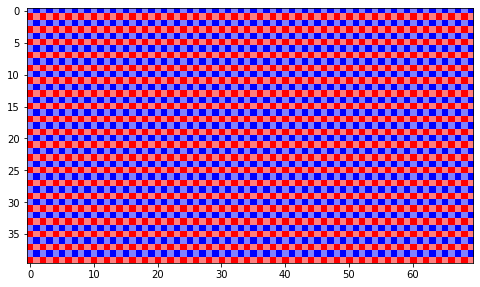

In [11]:
show_image(A, nuance="bwr", save=True)

In [12]:
B, S = subsample(A, 0.25)

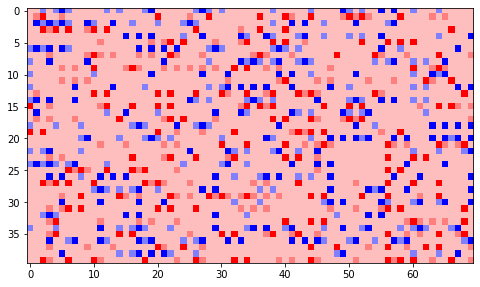

In [13]:
show_image(B, nuance='bwr', save=True)

C:\Users\Tom\AppData\Local\Temp/ipykernel_4544/2498325120.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))


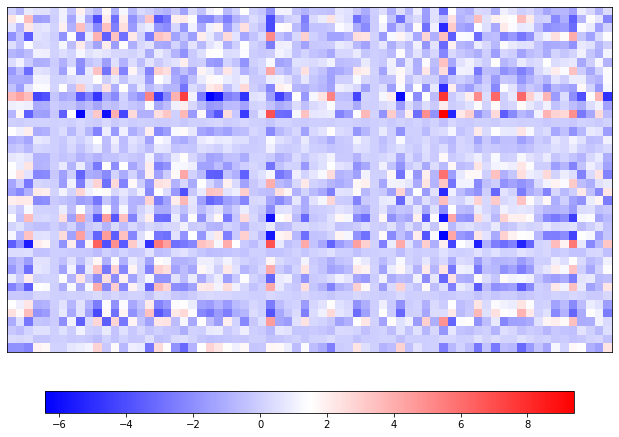

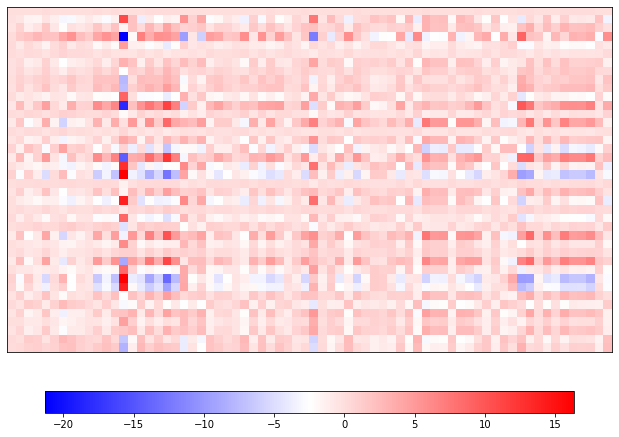

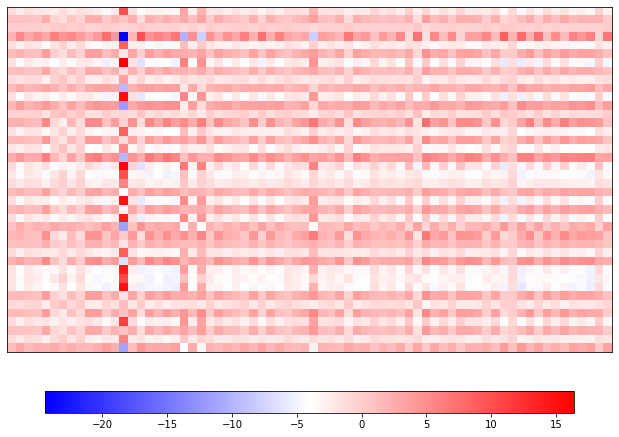

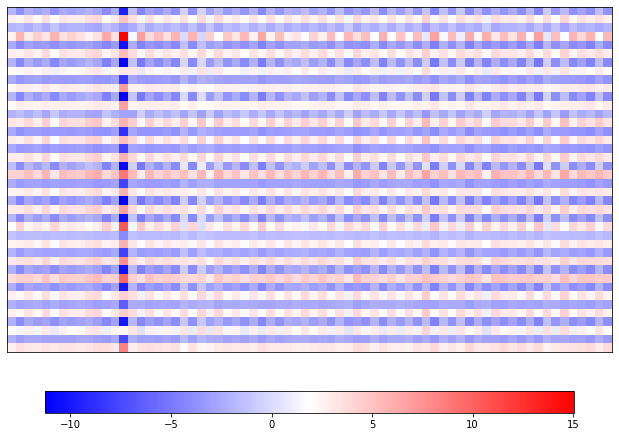

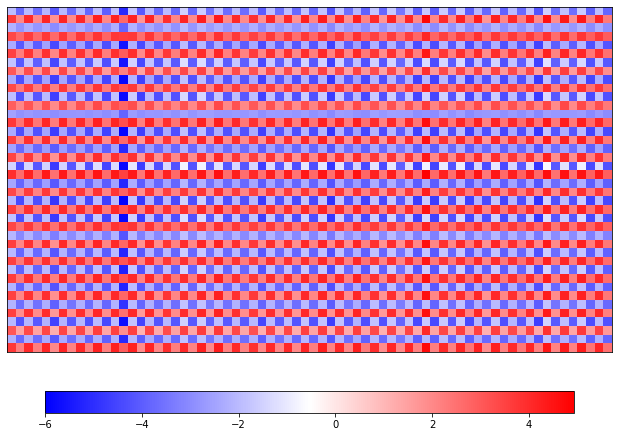

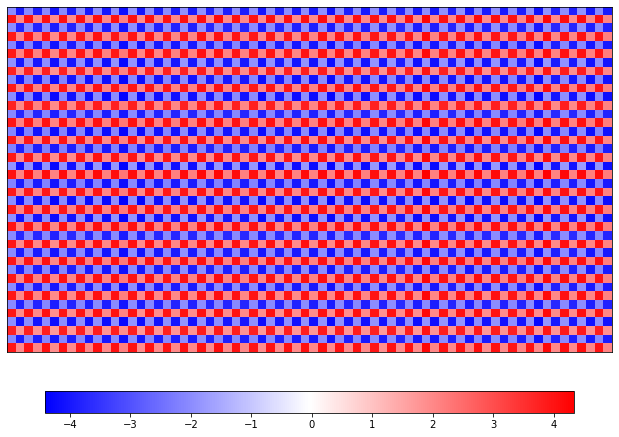

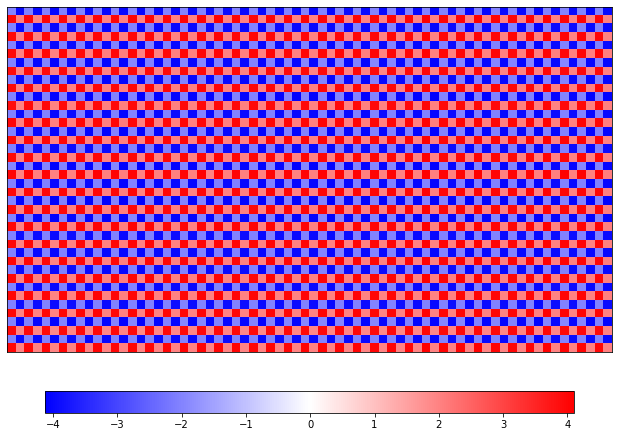

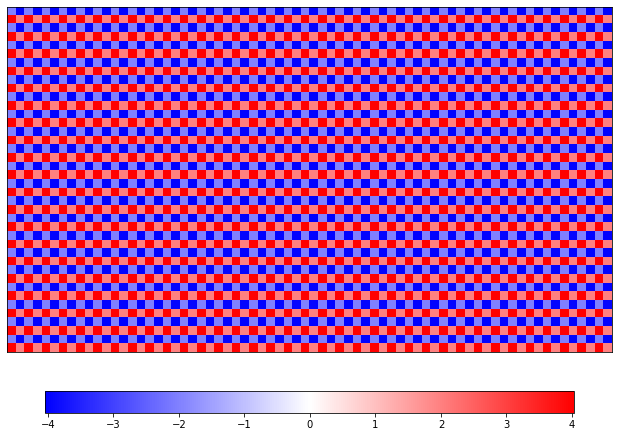

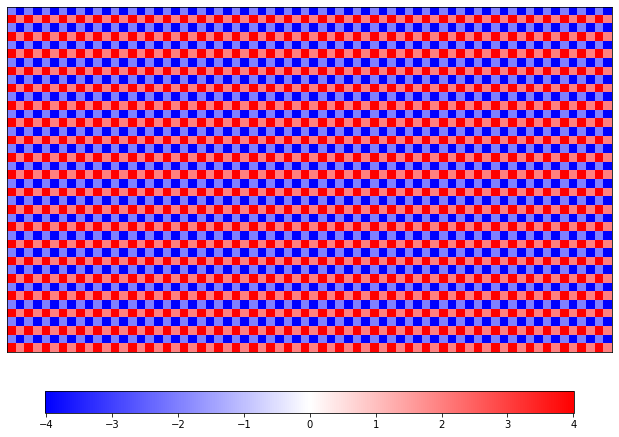

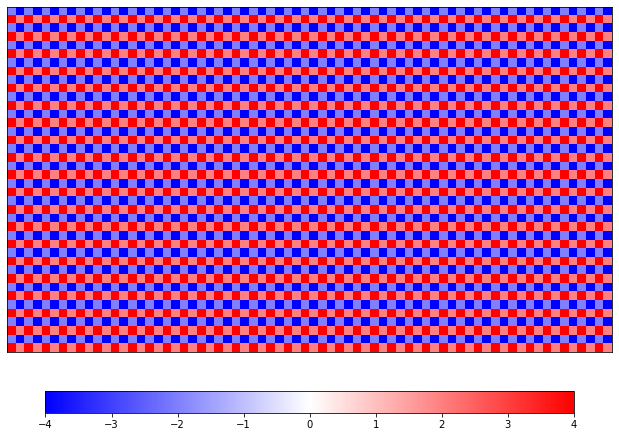

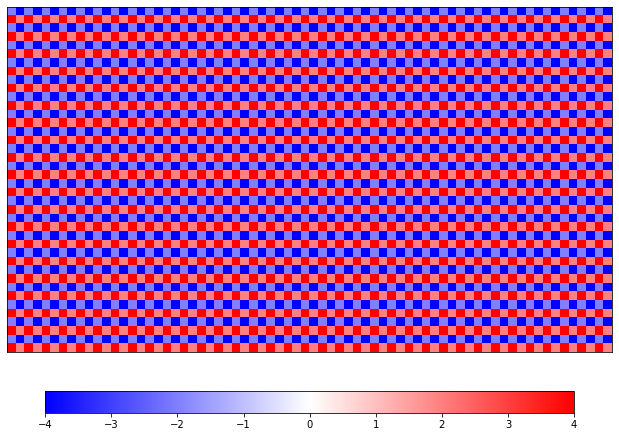

In [14]:
results = altmin(A, S, 2, 10)
for (U, V) in results:
    plot_decomposition(np.dot(U, V.T))

### Example 2

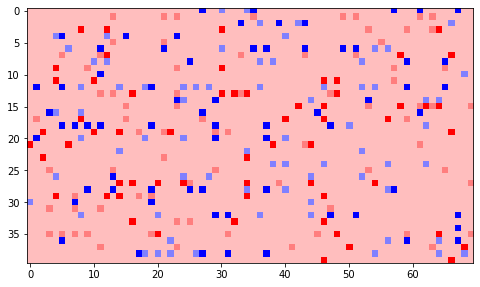

C:\Users\Tom\AppData\Local\Temp/ipykernel_4544/2498325120.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))


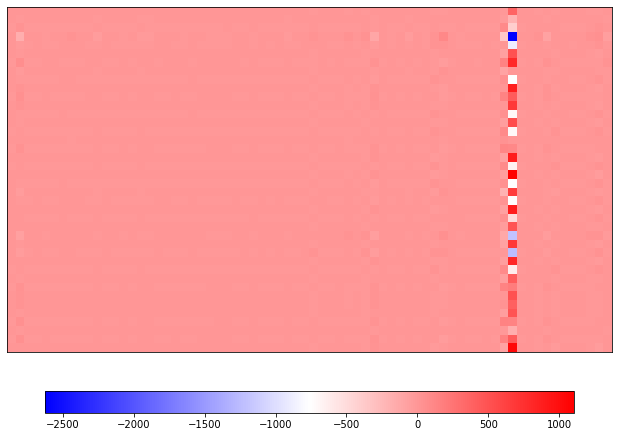

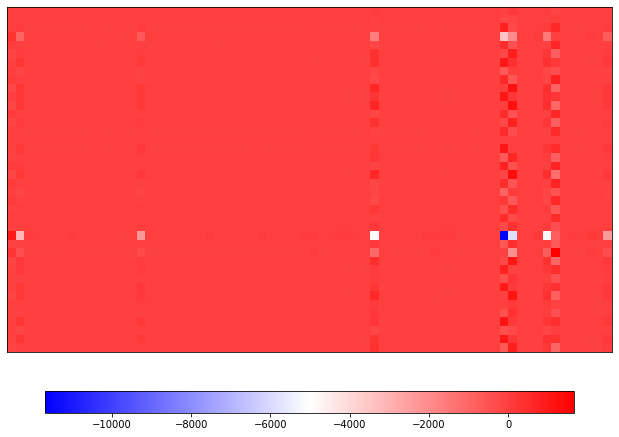

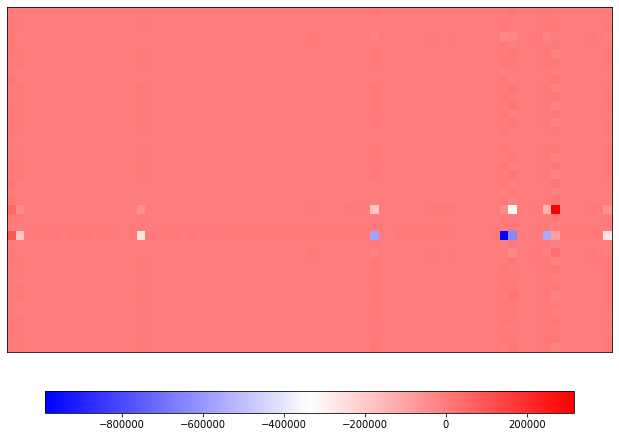

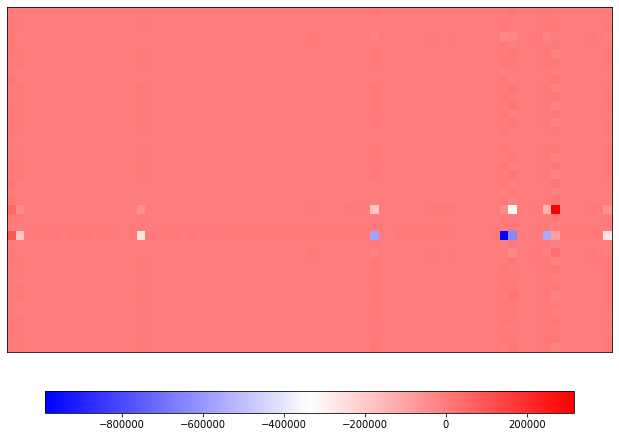

In [15]:
B, S = subsample(A, 0.1)
show_image(B, nuance='bwr', save=True)
results = altmin(A, S, 2, 1001)
plot_decomposition(np.dot(results[10][0], results[10][1].T))
plot_decomposition(np.dot(results[100][0], results[100][1].T))
plot_decomposition(np.dot(results[1000][0], results[1000][1].T))

### Images

In [16]:
def Algorithm(mat, sample=0.25, iter=10, nuance='bwr'):
    rk= np.linalg.matrix_rank(mat)
    plot_decomposition(mat, nuance=nuance)
    B, S = subsample(mat, sample)
    plot_decomposition(B, nuance=nuance)
    results = altmin(mat, S, rk, iter)
    for (U, V) in results:
        plot_decomposition(np.dot(U, V.T), nuance=nuance)


In [17]:
def Rank_reduction(mat, rk):
    u, s, vh = np.linalg.svd(mat)
    U_k = u[:,:rk]
    S_k = np.diag(s[:rk])
    Vh_k = vh[:rk]
    approx = np.dot(U_k, np.dot(S_k, Vh_k))
    return approx

In [18]:
from skimage import data
from skimage import io

In [19]:
images = data.lfw_subset()

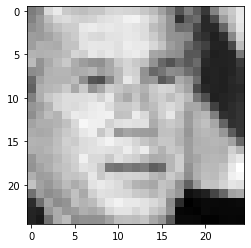

In [20]:
matrice = images[90]
plt.imshow(images[90], cmap=plt.cm.gray)

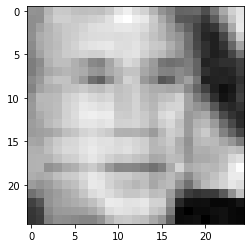

In [21]:
approx = Rank_reduction(matrice, 5)
plt.imshow(approx, cmap=plt.cm.gray)

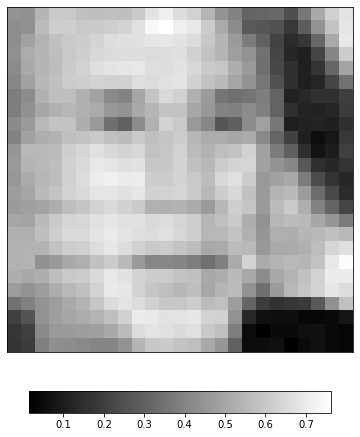

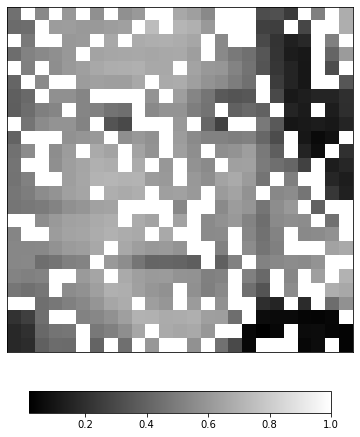

C:\Users\Tom\AppData\Local\Temp/ipykernel_4544/2498325120.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))


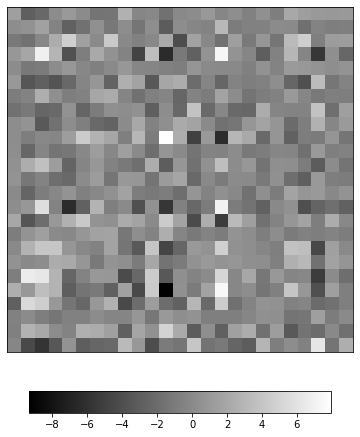

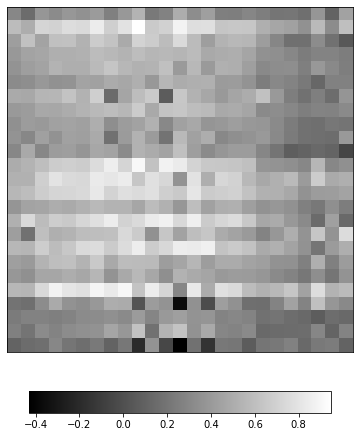

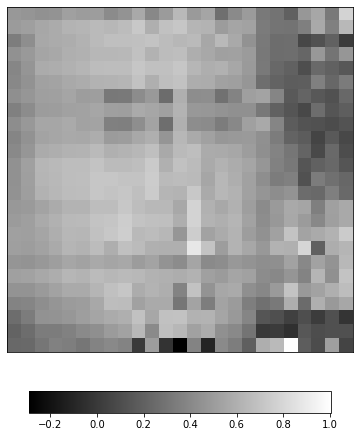

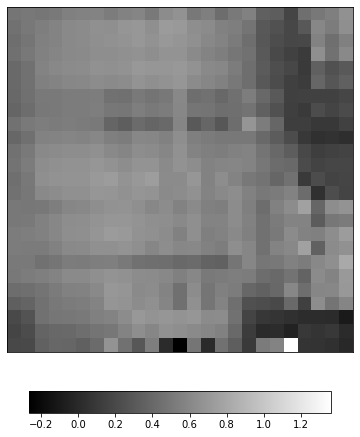

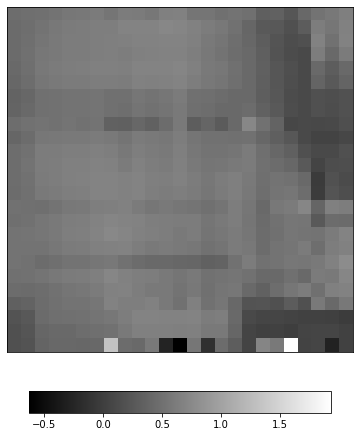

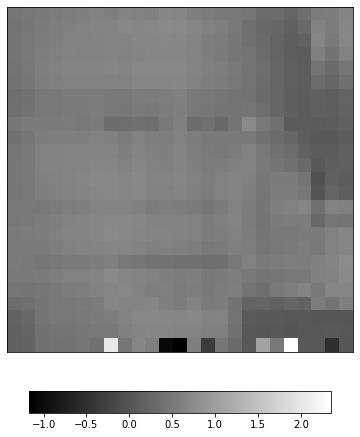

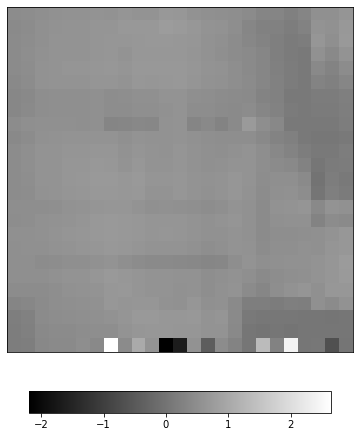

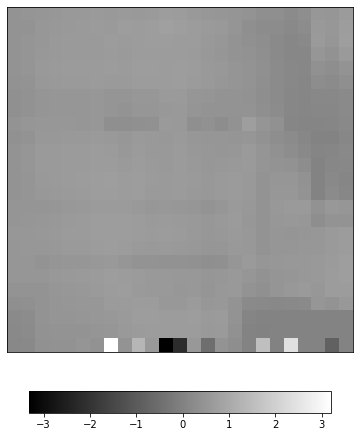

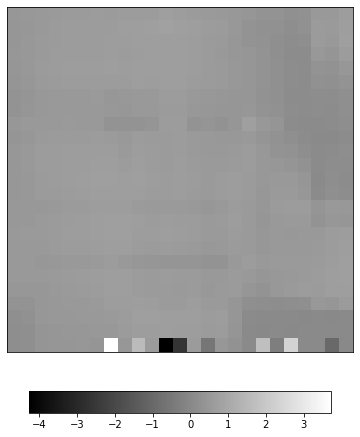

In [22]:
Algorithm(approx, nuance=plt.cm.gray, sample=0.7, iter=8)

Shape :  (480, 640)
Rank :  480


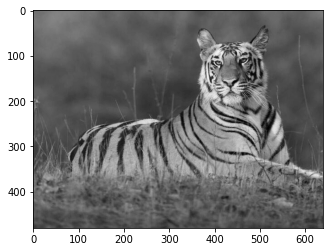

In [23]:
tiger = io.imread("Tiger.jpg", as_gray=True)
print("Shape : ", tiger.shape)
print("Rank : ", np.linalg.matrix_rank(tiger))
plt.imshow(tiger, cmap=plt.cm.gray)

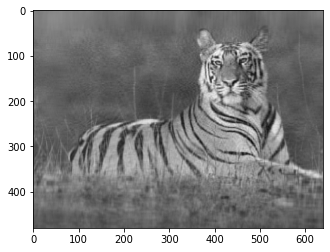

In [24]:
tiger_red = Rank_reduction(tiger, 50)
plt.imshow(tiger_red, cmap=plt.cm.gray)

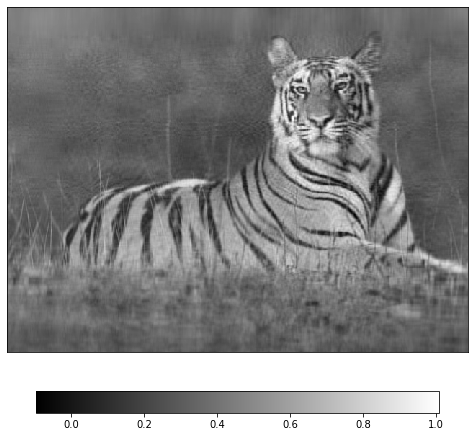

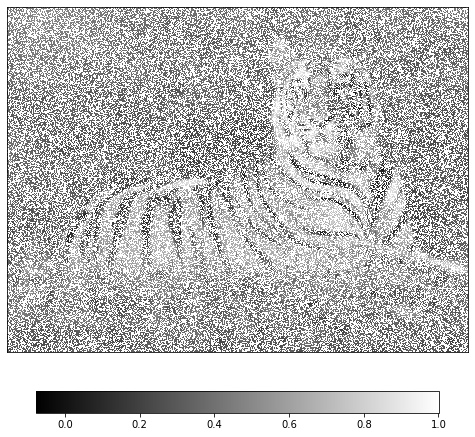

C:\Users\Tom\AppData\Local\Temp/ipykernel_4544/2498325120.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))


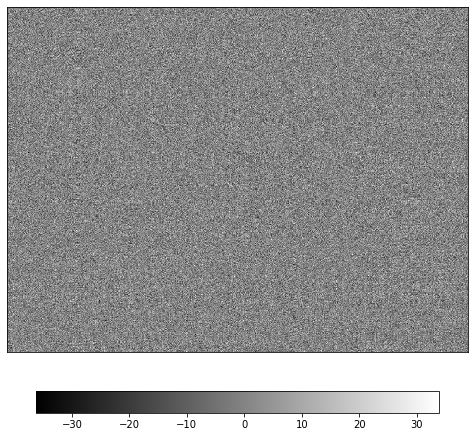

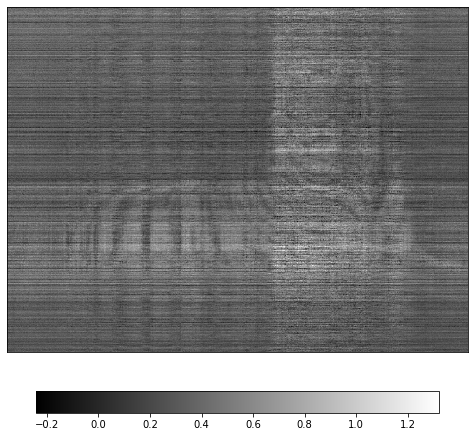

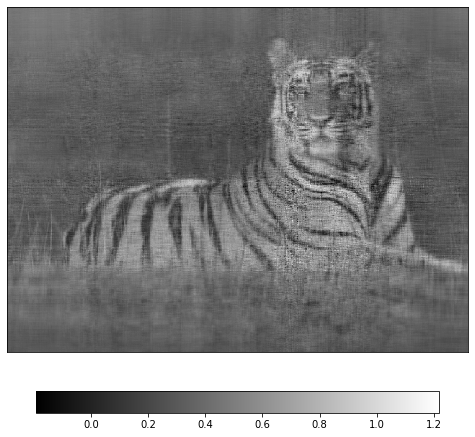

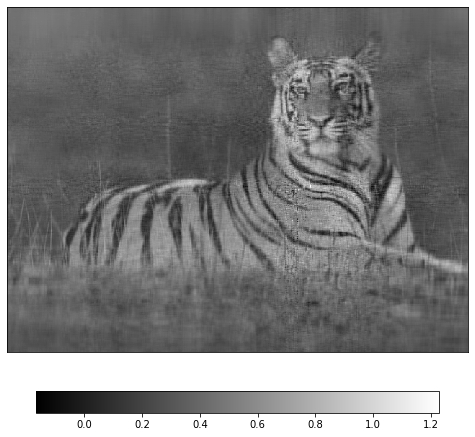

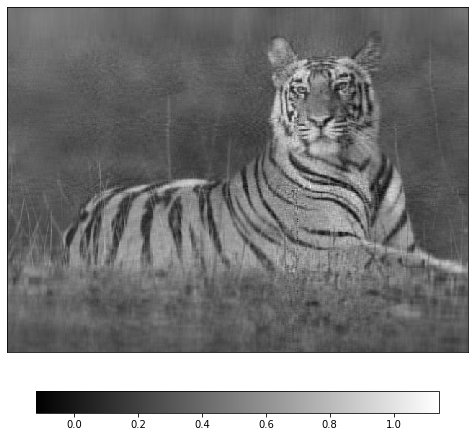

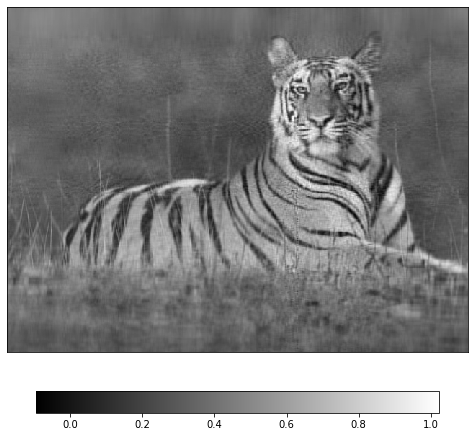

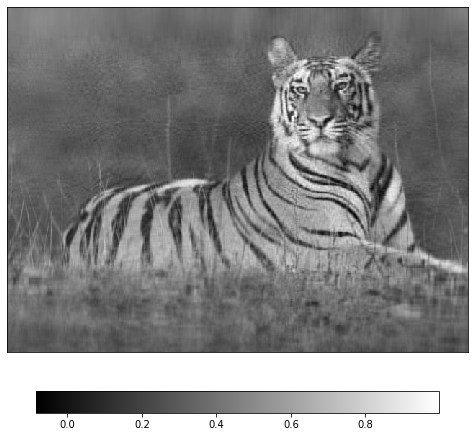

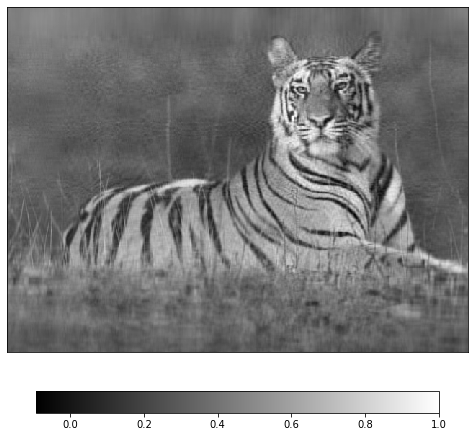

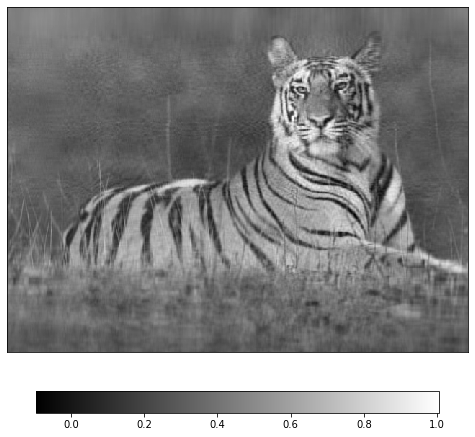

In [25]:
Algorithm(tiger_red, nuance=plt.cm.gray, sample=0.5, iter=8)

Shape :  (768, 1366)
Rank :  768


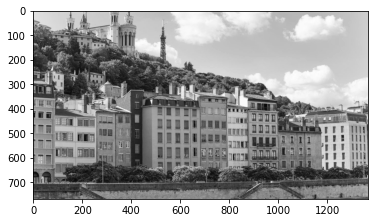

In [26]:
lyon = io.imread("Lyon.jpg", as_gray=True)
print("Shape : ", lyon.shape)
print("Rank : ", np.linalg.matrix_rank(lyon))
plt.imshow(lyon, cmap=plt.cm.gray)

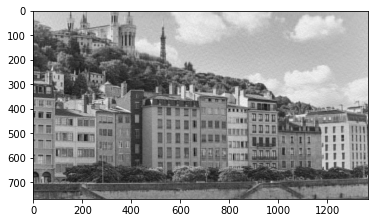

In [27]:
lyon_red = Rank_reduction(lyon, 100)
plt.imshow(lyon_red, cmap=plt.cm.gray)

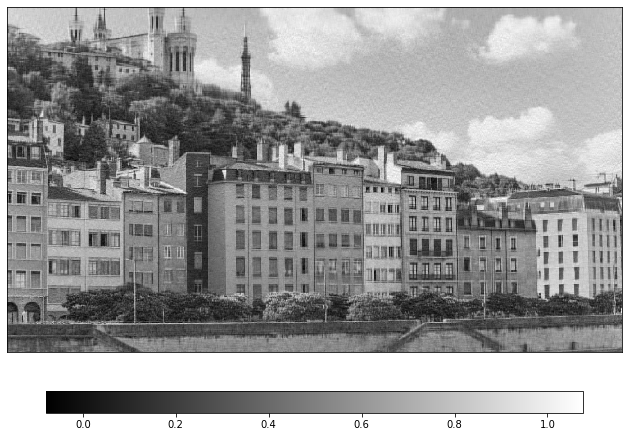

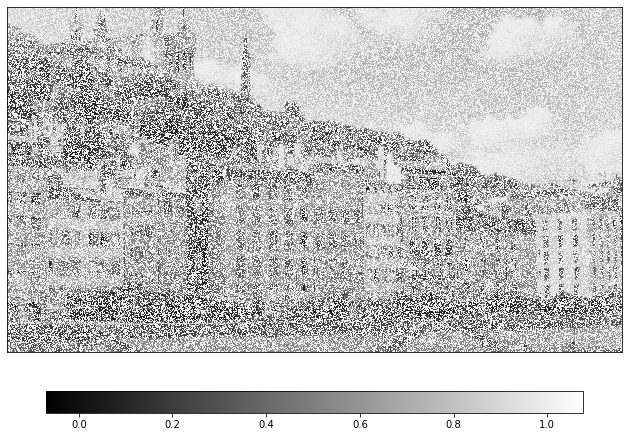

C:\Users\Tom\AppData\Local\Temp/ipykernel_4544/2498325120.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Y[i,:] = np.reshape(np.linalg.lstsq(siX, sia)[0], (rk,))


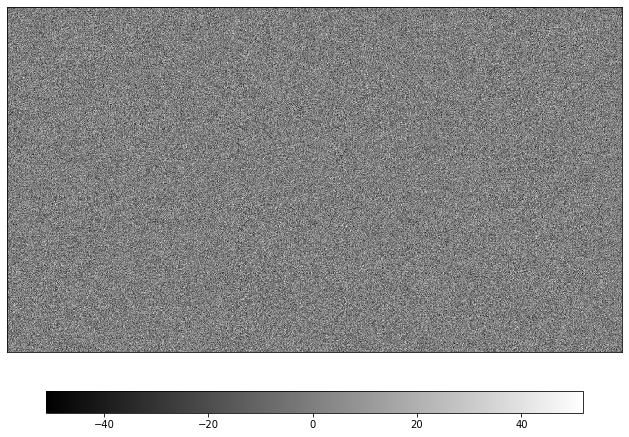

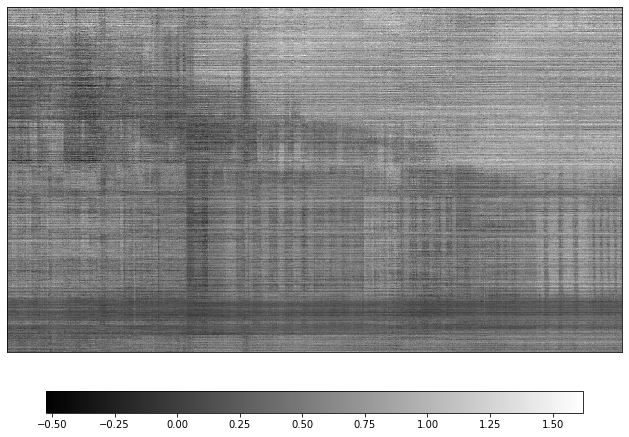

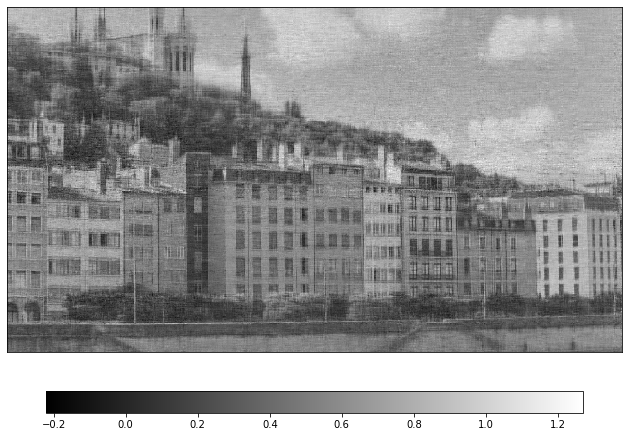

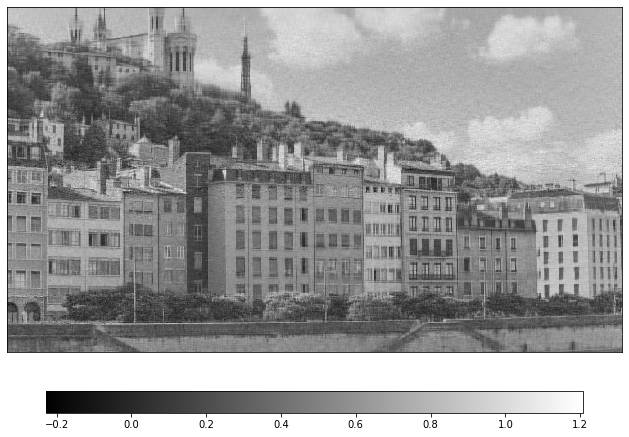

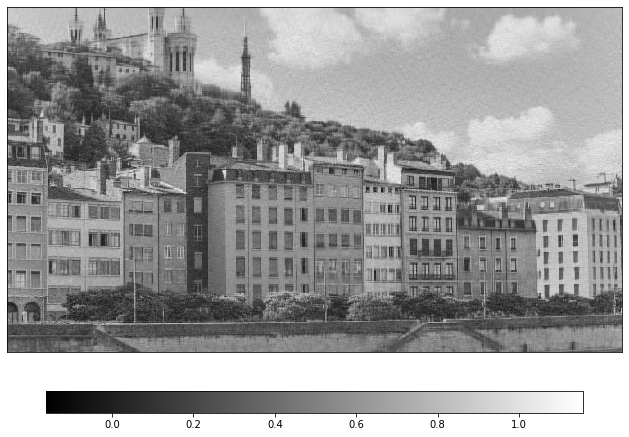

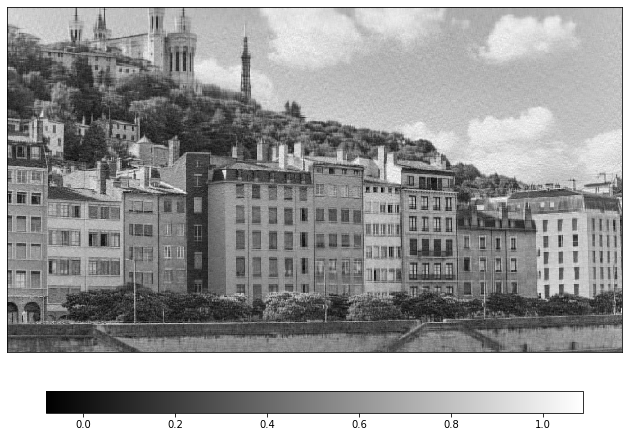

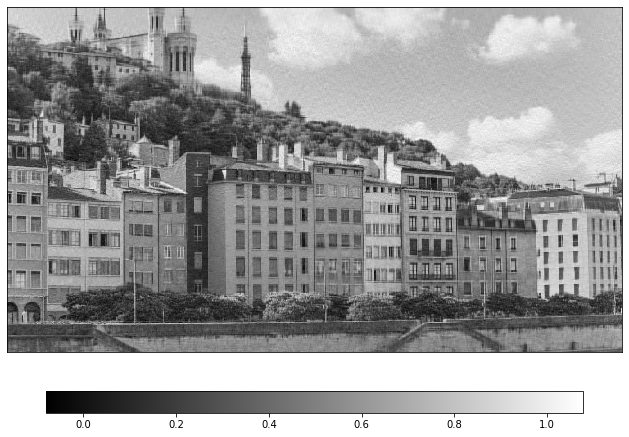

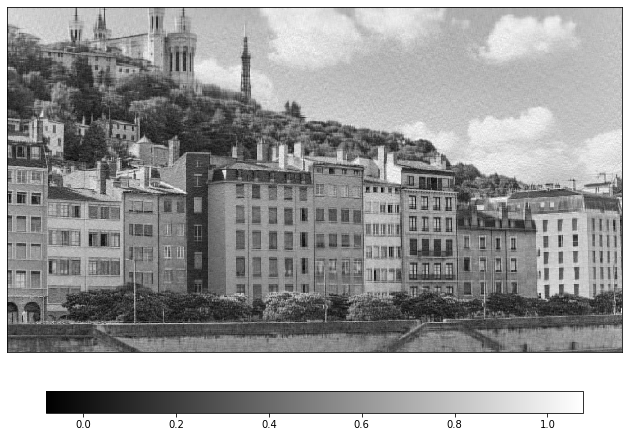

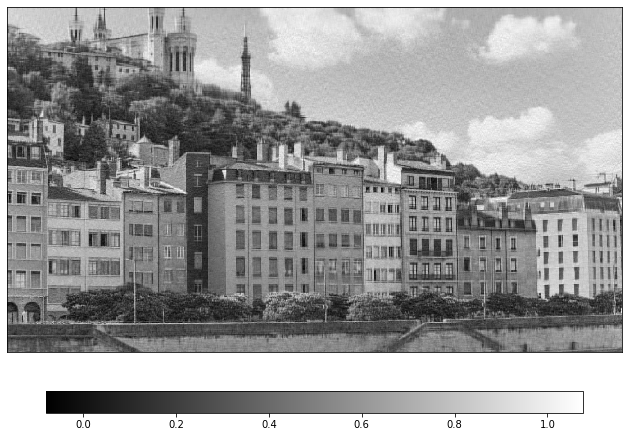

In [28]:
Algorithm(lyon_red, nuance=plt.cm.gray, sample=0.5, iter=8)